In [5]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

In [6]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [7]:
cleansed=load_amihud_markets_price()

In [8]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

In [44]:

a=(in_vol).sum(axis=1)
w=((in_vol).T.div(a)).T

In [49]:
w['2015'].ix[0].dropna().sort_values().tail()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


TIFFE-3 MTH EUROYEN TIBOR     0.116835
Federal Funds                 0.132745
LIFFE-3MTH STERLING           0.160888
CME-3 MTH EURODOLLAR COMP.    0.185635
ME-BANK ACCEPT. 90 DAY        0.270058
Name: 2015-01-31 00:00:00, dtype: float64

In [103]:
mkts=quantile_columns(amihud.resample(rule='a',how='median'),'2014-12-31',3,0)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  """Entry point for launching an IPython kernel.


In [102]:
mkts

['MEXDER-IPC INDEX',
 'LIFFE-COCOA',
 'OSLO-OBX INDEX',
 'SHFE-ALUMINIUM',
 'Dow Jones',
 'LIFFE-WHITE SUGAR',
 'ICE CANADA-CANOLA',
 'LIFFE-ROBUSTA COFFEE REVISED',
 'NYM-PLATINUM',
 'SHFE-ZINC',
 'CMX-SILVER 5000 OZ',
 'CMX-HIGH GRADE COPPER',
 'DCE-LLDPE',
 'SHFE-NATURAL RUBBER',
 'SGX DT-NIKKEI STOCK AVG DIV',
 'Richards Bay Coal',
 'NYM-PALLADIUM',
 'EEX-QUARTERLY BASE LOAD',
 'DCE-COKE',
 'TOCOM-GOLD',
 'EEX-YEARLY PEAKLOAD',
 'NYCE-(FCOJ-A) ORANGE JUICE',
 'CME-LUMBER',
 'CBT-ROUGH RICE',
 'CME-MILK CLASS III GLOBEX',
 'ZCE-FLAT GLASS',
 'BMF-ARABICA COFFEE',
 'TGE-SOYBEANS',
 'TGE-CORN',
 'SHFE-GOLD',
 'TOCOM-PLATINUM',
 'Ethanol (Chicago2)',
 'NORDPOOL-ENO',
 'SAFEX-WHITE MAIZE',
 'TGE-AZUKI (RED BEAN)',
 'Rotterdam Coal',
 'SAFEX-INDUSTRIAL 25 INDEX',
 'TOCOM-RUBBER',
 'AEX-AEX INDEX',
 'TOCOM-SILVER',
 'TOCOM-PALLADIUM']

In [104]:
mkts

['MXN',
 'CME-3 MTH EURODOLLAR COMP.',
 'SFE-30 DAY INTERBANK CASH',
 'SFE-AUST 90 DAY BANK BILLS',
 'EUREX-EURO SCHATZ',
 'LIFFE-3MTH STERLING',
 'TSE-10 YEAR T-BOND',
 'CBT-10 YRS US T-NOTE COMP.',
 'CBT-2 YEAR US T-NOTE COMP.',
 'Federal Funds',
 'CBT-5 YEAR US T-NOTE COMP.',
 'EUREX-EURO BOBL',
 'TIFFE-3 MTH EUROYEN TIBOR',
 'CME-MINI S&P 500 INDEX',
 'ME-BANK ACCEPT. 90 DAY',
 'SFE-AUST 10 YEAR T-BOND',
 'EuroSwiss',
 'SFE-NZ 90 DAY BANK BILLS',
 'CBT-30 YR US T-BOND COMP',
 'EUR',
 'KSE-KOSPI 200 INDEX',
 'EUREX-DJ EURO STOXX 50',
 'LIFFE-LONG GILT',
 'ICE-BRENT CRUDE OIL',
 'EUREX-LONG EURO OAT',
 'Nasdaq',
 'ICE-NATURAL GAS SEASON',
 'Cotton',
 'GBP',
 'DAX',
 'NYM-LIGHT CRUDE OIL',
 'AUD',
 'ME-10Y CANADIAN GOVT BOND',
 'Corn',
 'EUREX-EURO BTP',
 'CHF',
 'Russell 2000',
 'CME-EURO COMP.',
 'CAD']

In [62]:
a=(in_vol['2015'][mkts]).sum(axis=1)
w=((in_vol['2015'][mkts]).T.div(a)).T

In [64]:
w.sum(axis=1)

Date
2015-01-31    1.0
2015-02-28    1.0
2015-03-31    1.0
2015-04-30    1.0
2015-05-31    1.0
2015-06-30    1.0
2015-07-31    1.0
2015-08-31    1.0
2015-09-30    1.0
2015-10-31    1.0
2015-11-30    1.0
2015-12-31    1.0
Freq: M, dtype: float64

In [74]:
cleansed.resample(rule='m',how='last')[mkts].pct_change()['2015']

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


,MEXDER-IPC INDEX,LIFFE-COCOA,OSLO-OBX INDEX,SHFE-ALUMINIUM,Dow Jones,LIFFE-WHITE SUGAR,ICE CANADA-CANOLA,LIFFE-ROBUSTA COFFEE REVISED,NYM-PLATINUM,SHFE-ZINC,...,Ethanol (Chicago2),NORDPOOL-ENO,SAFEX-WHITE MAIZE,TGE-AZUKI (RED BEAN),Rotterdam Coal,SAFEX-INDUSTRIAL 25 INDEX,TOCOM-RUBBER,AEX-AEX INDEX,TOCOM-SILVER,TOCOM-PALLADIUM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,-0.050800,-0.035461,0.039563,-0.017328,-0.036897,-0.020679,-0.000883,0.025370,0.018289,-0.016970,...,-0.175513,0.047078,-0.010849,0.005643,-0.143820,NaN,-0.025967,0.054941,0.050000,-0.055270
2015-02-28,0.082449,0.069853,0.024564,0.010188,0.060244,-0.029979,0.017005,-0.033505,-0.032426,-0.007707,...,0.056328,-0.217984,0.263710,-0.010101,0.112861,NaN,0.160481,0.077952,0.015873,0.047279
2015-03-31,-0.019493,-0.066765,0.005232,0.031808,-0.023391,-0.042999,-0.010423,-0.040000,-0.040736,-0.011805,...,0.029778,0.015067,-0.003774,-0.010204,-0.074686,NaN,-0.063063,0.010656,0.015625,-0.075349
2015-04-30,0.026546,0.047870,0.031266,-0.001504,0.003163,0.052233,0.015800,-0.024444,0.009018,0.067903,...,0.088769,-0.052734,-0.026515,0.028637,0.016143,NaN,0.027404,-0.014331,-0.076923,0.046013
2015-05-31,0.002351,0.058735,0.006534,-0.015060,0.014077,-0.066987,0.020955,-0.101367,-0.030632,-0.010892,...,-0.053119,-0.350515,0.058366,-0.006682,-0.027592,NaN,0.075807,0.028456,0.100000,0.034251
2015-06-30,0.003574,0.015647,-0.023286,-0.025229,0.003861,0.062929,0.146424,0.190114,-0.030525,-0.087500,...,0.051533,-0.149206,0.160662,-0.001121,0.035254,NaN,-0.108308,-0.043017,-0.075758,-0.136364
2015-07-31,-0.004451,-0.005602,0.010708,-0.054902,NaN,-0.058127,-0.073643,-0.055911,-0.087627,-0.022831,...,-0.066377,-0.149254,0.008869,-0.021324,-0.057309,NaN,-0.059512,0.039886,-0.049180,-0.035714
2015-08-31,-0.030852,-0.025352,-0.073358,-0.017427,NaN,-0.028286,-0.052799,-0.117315,0.022973,-0.009346,...,-0.029900,0.635965,-0.028006,0.020642,-0.031718,NaN,-0.144191,-0.098935,0.034483,-0.115400
2015-09-30,-0.015110,0.035164,-0.027671,-0.016047,NaN,0.082917,0.003366,0.015974,-0.101207,-0.049865,...,0.051370,-0.080429,0.022353,-0.084270,-0.064604,NaN,-0.070303,-0.048536,-0.066667,0.121639


In [75]:
w.multiply(cleansed.resample(rule='m',how='last')[mkts].pct_change()['2015'])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


,MEXDER-IPC INDEX,LIFFE-COCOA,OSLO-OBX INDEX,SHFE-ALUMINIUM,Dow Jones,LIFFE-WHITE SUGAR,ICE CANADA-CANOLA,LIFFE-ROBUSTA COFFEE REVISED,NYM-PLATINUM,SHFE-ZINC,...,Ethanol (Chicago2),NORDPOOL-ENO,SAFEX-WHITE MAIZE,TGE-AZUKI (RED BEAN),Rotterdam Coal,SAFEX-INDUSTRIAL 25 INDEX,TOCOM-RUBBER,AEX-AEX INDEX,TOCOM-SILVER,TOCOM-PALLADIUM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,-0.001681,-0.001130,0.001691,-0.000867,-0.001759,-0.000641,-0.000015,0.000426,0.000529,-0.000948,...,-0.001246,0.000529,-0.000138,0.000101,-0.003471,NaN,-0.000399,0.002148,0.000737,-0.001060
2015-02-28,0.002552,0.002187,0.001061,0.000521,0.002719,-0.000976,0.000303,-0.000569,-0.000962,-0.000446,...,0.000405,-0.002318,0.003014,-0.000186,0.002542,NaN,0.002316,0.002982,0.000240,0.000925
2015-03-31,-0.000604,-0.001959,0.000228,0.001569,-0.001046,-0.001397,-0.000187,-0.000680,-0.001205,-0.000756,...,0.000215,0.000169,-0.000044,-0.000191,-0.001672,NaN,-0.000913,0.000411,0.000238,-0.001435
2015-04-30,0.000868,0.001456,0.001397,-0.000077,0.000146,0.001666,0.000293,-0.000430,0.000276,0.003787,...,0.000661,-0.000643,-0.000321,0.000551,0.000371,NaN,0.000410,-0.000564,-0.001245,0.000908
2015-05-31,0.000077,0.001787,0.000292,-0.000776,0.000653,-0.002100,0.000386,-0.001738,-0.000931,-0.000600,...,-0.000395,-0.003620,0.000706,-0.000129,-0.000633,NaN,0.001114,0.001128,0.001568,0.000704
2015-06-30,0.000126,0.000478,-0.001087,-0.001284,0.000178,0.001883,0.002414,0.002870,-0.001065,-0.003734,...,0.000376,-0.001495,0.001841,-0.000021,0.000813,NaN,-0.001522,-0.001687,-0.001287,-0.002976
2015-07-31,-0.000179,-0.000190,0.000555,-0.002683,NaN,-0.001757,-0.001494,-0.000887,-0.003192,-0.000992,...,-0.000500,-0.001615,0.000105,-0.000415,-0.001355,NaN,-0.000859,0.001706,-0.000863,-0.000888
2015-08-31,-0.001273,-0.000864,-0.003226,-0.000868,NaN,-0.000866,-0.001103,-0.001849,0.000833,-0.000415,...,-0.000229,0.004674,-0.000335,0.000408,-0.000758,NaN,-0.002056,-0.003507,0.000748,-0.002648
2015-09-30,-0.000626,0.001209,-0.001192,-0.000809,NaN,0.002347,0.000073,0.000257,-0.003327,-0.002107,...,0.000404,-0.000598,0.000269,-0.001711,-0.001655,NaN,-0.001000,-0.001668,-0.001484,0.002594


In [91]:
vol=pd.DataFrame.rolling(cleansed.resample(rule='m',how='last').pct_change(),24).std()
in_vol=1/(vol.replace(0,1))

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [92]:
in_vol['2000']

,CME-3 MTH EURODOLLAR COMP.,SFE-AUST 90 DAY BANK BILLS,EUREX-EURO SCHATZ,SFE-30 DAY INTERBANK CASH,TIFFE-3 MTH EUROYEN TIBOR,EUREX-EURO BOBL,TSE-10 YEAR T-BOND,CBT-10 YRS US T-NOTE COMP.,ME-BANK ACCEPT. 90 DAY,CBT-5 YEAR US T-NOTE COMP.,...,Rotterdam Coal,Milling Wheat,AUD,CHF,GBP,NZD,CAD,JPY,MXN,EUR
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,600.950114,394.385167,252.874922,NaN,894.016796,121.302537,46.309033,34.604219,350.899415,47.775077,...,NaN,NaN,33.379698,37.243305,60.148892,NaN,55.756207,19.521058,27.251911,NaN
2000-02-29,602.499691,392.998508,252.377292,NaN,899.063291,120.714303,46.057025,34.407482,354.562665,47.321585,...,NaN,NaN,33.022810,37.349919,58.503912,NaN,57.775358,19.314670,26.597042,NaN
2000-03-31,596.683810,378.792261,257.190084,NaN,929.153961,120.587957,46.017800,33.728019,354.593822,47.068647,...,NaN,NaN,33.215397,38.227088,58.959045,NaN,57.856564,18.828669,26.761640,NaN
2000-04-30,563.171345,378.454453,255.683738,NaN,928.788326,120.263421,46.084318,33.728452,355.492634,47.098617,...,NaN,NaN,32.427177,37.230112,56.697703,NaN,56.300567,18.165475,26.925104,NaN
2000-05-31,533.544511,375.957133,254.595398,NaN,929.093168,121.555833,46.462267,33.842595,328.351909,47.183879,...,NaN,NaN,33.316919,36.691578,54.366308,NaN,57.131310,18.580430,27.233610,NaN
2000-06-30,515.966026,390.148241,253.471192,NaN,883.195813,121.697970,46.422678,33.418899,325.161367,46.621694,...,NaN,NaN,31.755870,35.339878,55.088073,NaN,56.651883,18.551834,27.132812,NaN
2000-07-31,515.079535,392.476605,254.680168,NaN,874.696651,122.362215,46.373774,33.354584,328.350141,46.562994,...,NaN,NaN,31.451792,35.347309,55.822471,NaN,60.470110,18.641832,25.872052,NaN
2000-08-31,519.644372,410.012539,300.905359,NaN,840.504534,147.591788,46.478183,34.111805,400.038311,47.583903,...,NaN,NaN,33.955280,35.136581,57.465710,NaN,70.064178,18.648674,30.867120,NaN
2000-09-30,566.763988,631.467512,298.904703,NaN,823.657889,144.288873,47.999115,35.936942,533.194893,49.957183,...,NaN,NaN,32.733729,38.664721,56.072753,NaN,71.416670,18.727218,32.919783,NaN


In [93]:
def quantile_portfolios_annual_with_rank_vol_weighting(rank_data,price_data,number_of_buckets=10):
    deciles={}
    med_value={}
    vol=pd.DataFrame.rolling(price_data.resample(rule='m',how='last').pct_change(),24).std()
    in_vol=1/(vol.replace(0,1))
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
        med_value[str(i)]=pd.Series()
    for y in range(rank_data.dropna(how='all').index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
            a=(in_vol[str(y+1)][mkts]).sum(axis=1)
            w=((in_vol[str(y+1)][mkts]).T.div(a)).T
            rtns = w.multiply(rank_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)]).sum(axis=1)
            med=rank_data[mkts][str(y+1)].median(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
            med_value[str(i)]=med_value[str(i)].append(med)
    return pd.DataFrame(deciles),pd.DataFrame(med_value)

In [98]:
a,b=quantile_portfolios_annual_with_rank_vol_weighting(amihud,cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  if sys.path[0] == '':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from ipykernel import kernelapp as app


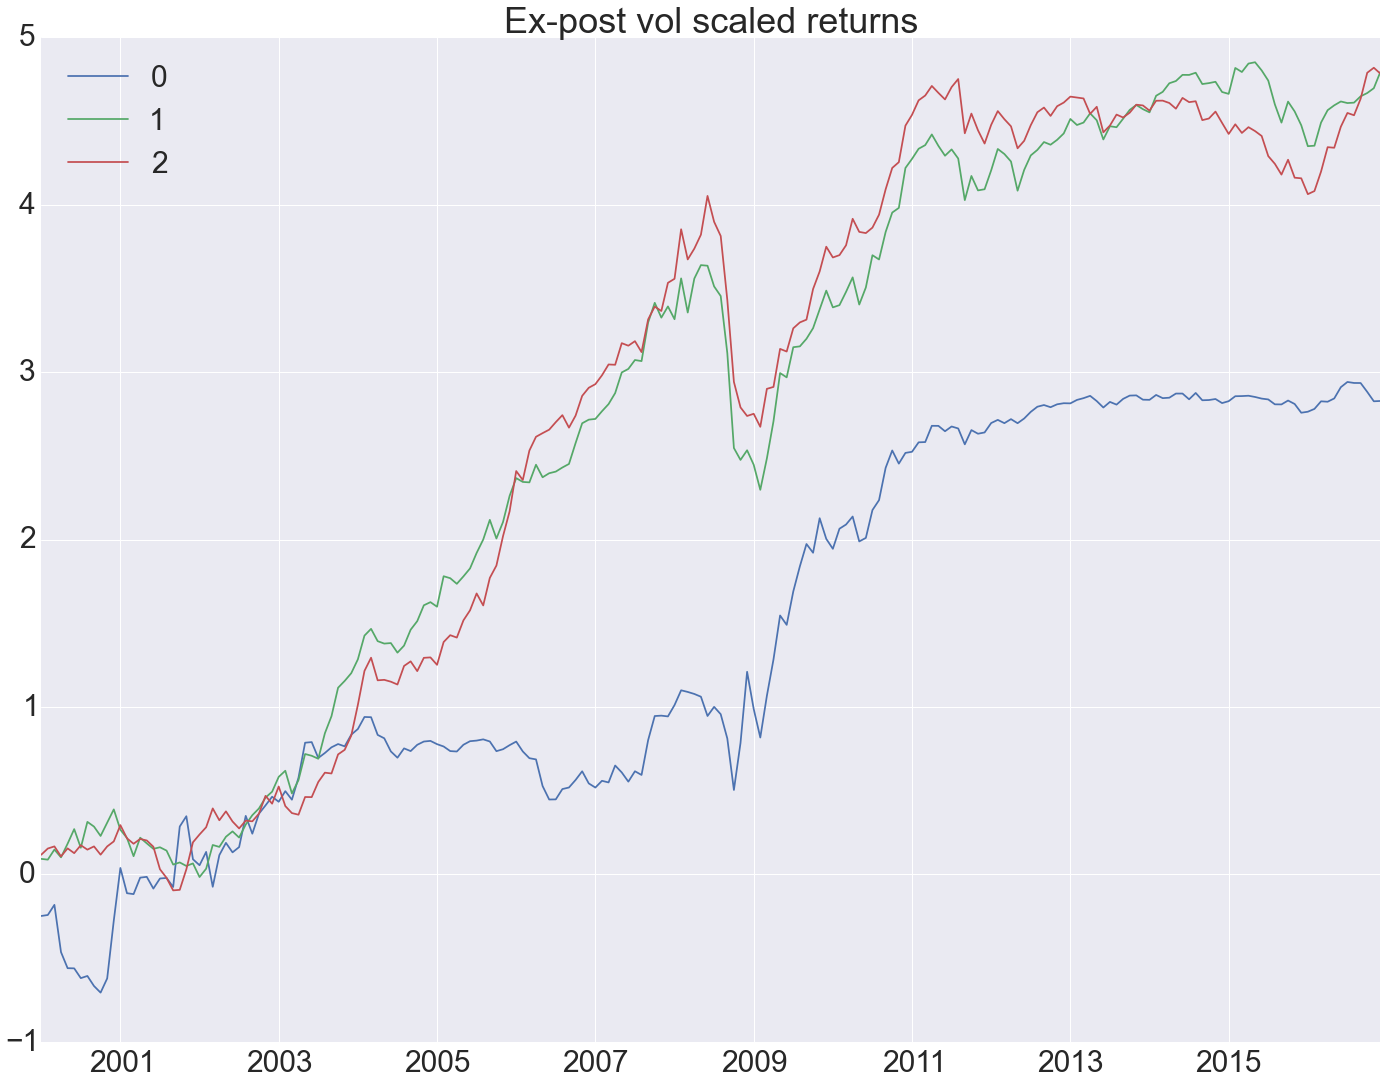

In [115]:
final=((a*.1)/a.std())
final.cumsum().plot(title='Ex-post vol scaled returns')

Some interesting findings
* The one seemingly right feature about this is that you get slaughtered during the financial crisis
* Very little returns after the crisis given the amount of QE pumped into the markets to give the illusion that everything is liquid
* Now that QE is ending we are starting to see the returns

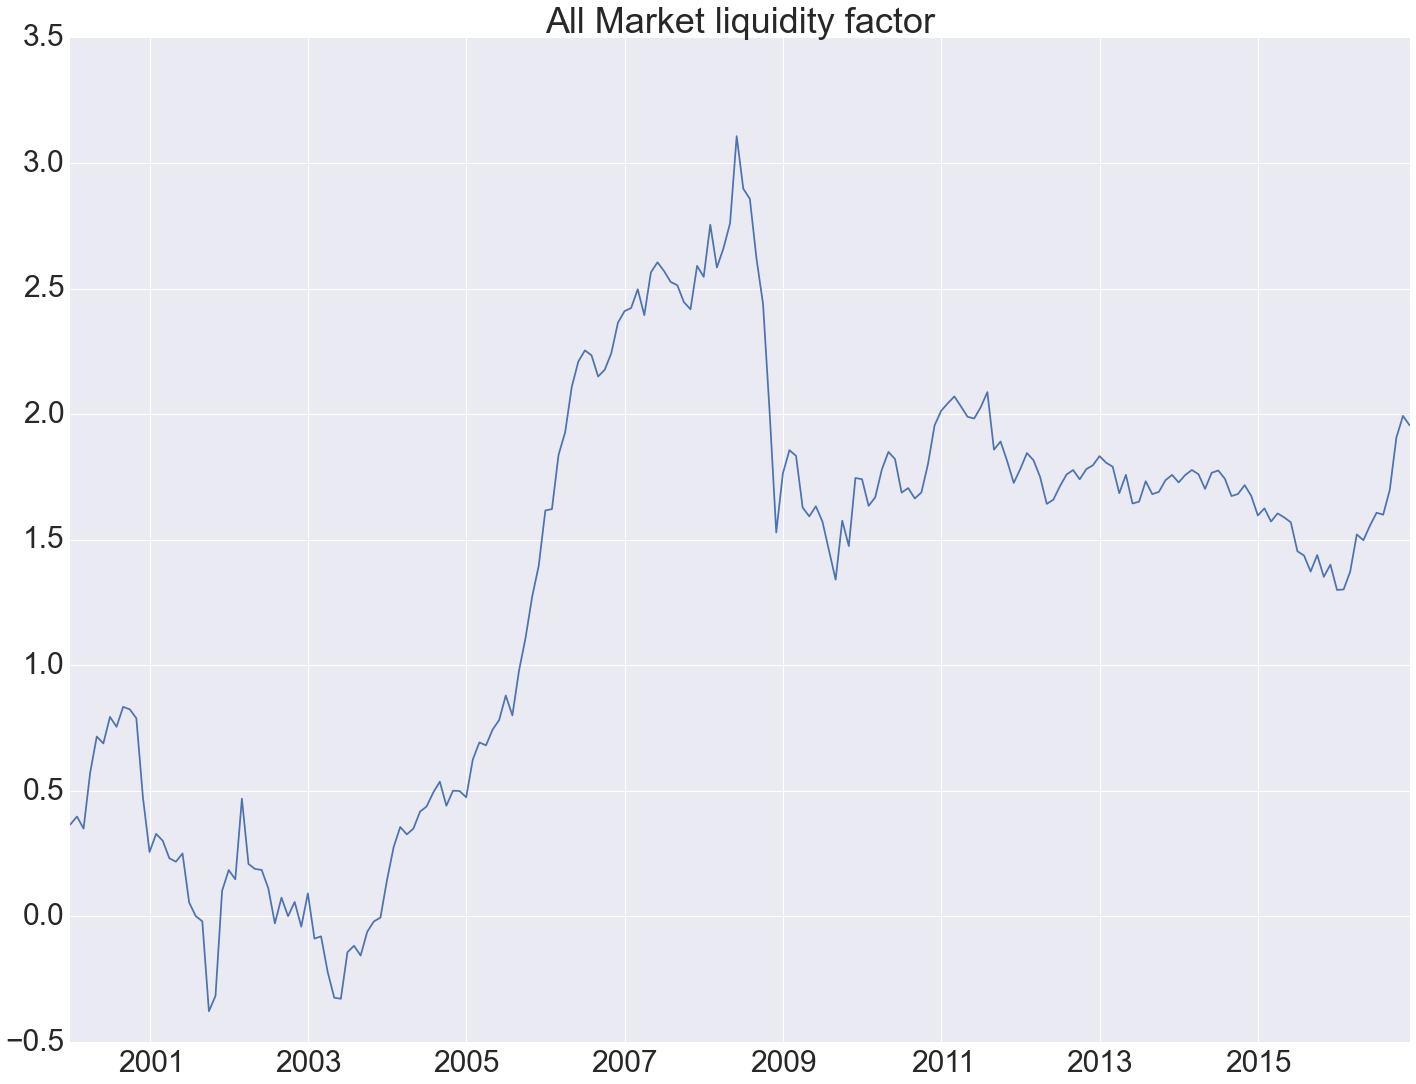

In [117]:
(final['2']-final['0']).cumsum().plot(title='All Market liquidity factor')

# Try to vol scale returns

In [127]:
def quantile_portfolios_annual_vol_scaled_rtns(rank_data,price_data,number_of_buckets=10):
    rets=price_data.resample(rule='m',how='last').pct_change()
    rets_scaled=(.1*rets)/rets.std()
    deciles={}
    for i in range(0,number_of_buckets,1):
        deciles[str(i)]=pd.Series()
    for y in range(rank_data.index[0].year,rank_data.index[-1].year,1):
        year=str(y) + '-12-31'
        for i in range(0,number_of_buckets,1):
            mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
            rtns = rets_scaled[mkts][str(y+1)].mean(axis=1)
            deciles[str(i)]=deciles[str(i)].append(rtns)
    return pd.DataFrame(deciles)

In [129]:
x=quantile_portfolios_annual_vol_scaled_rtns(amihud,cleansed,3)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.


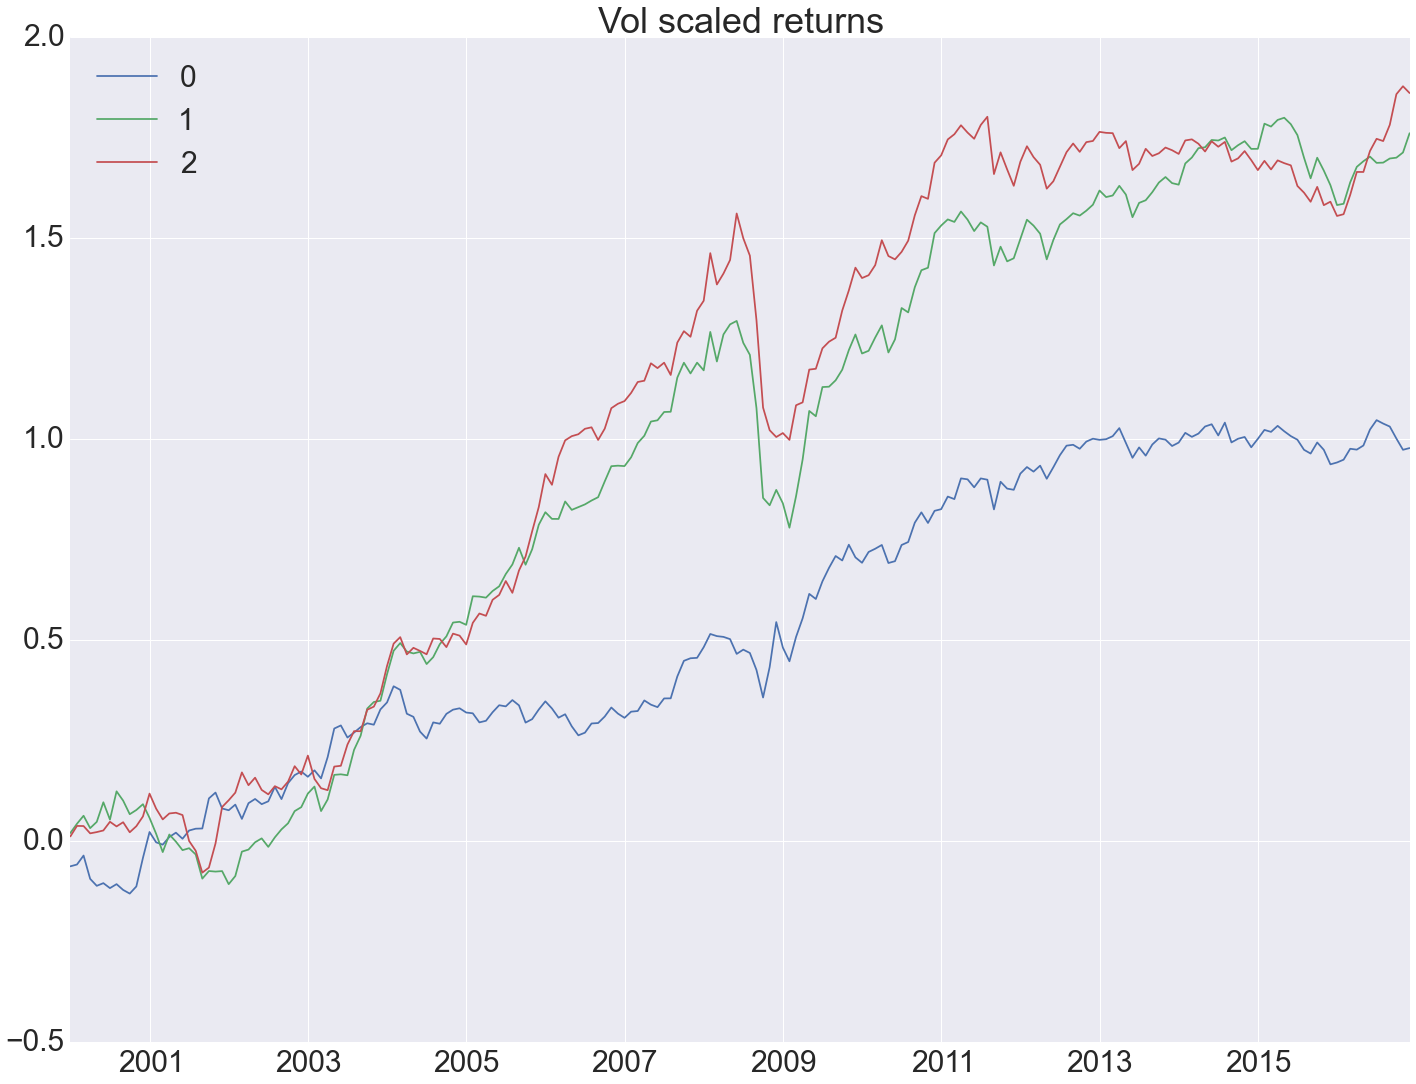

In [134]:
x.dropna().cumsum().plot(title='Vol scaled returns')

In [137]:
x.std()*math.sqrt(12)*100.

0     9.960972
1    13.838651
2    14.646263
dtype: float64

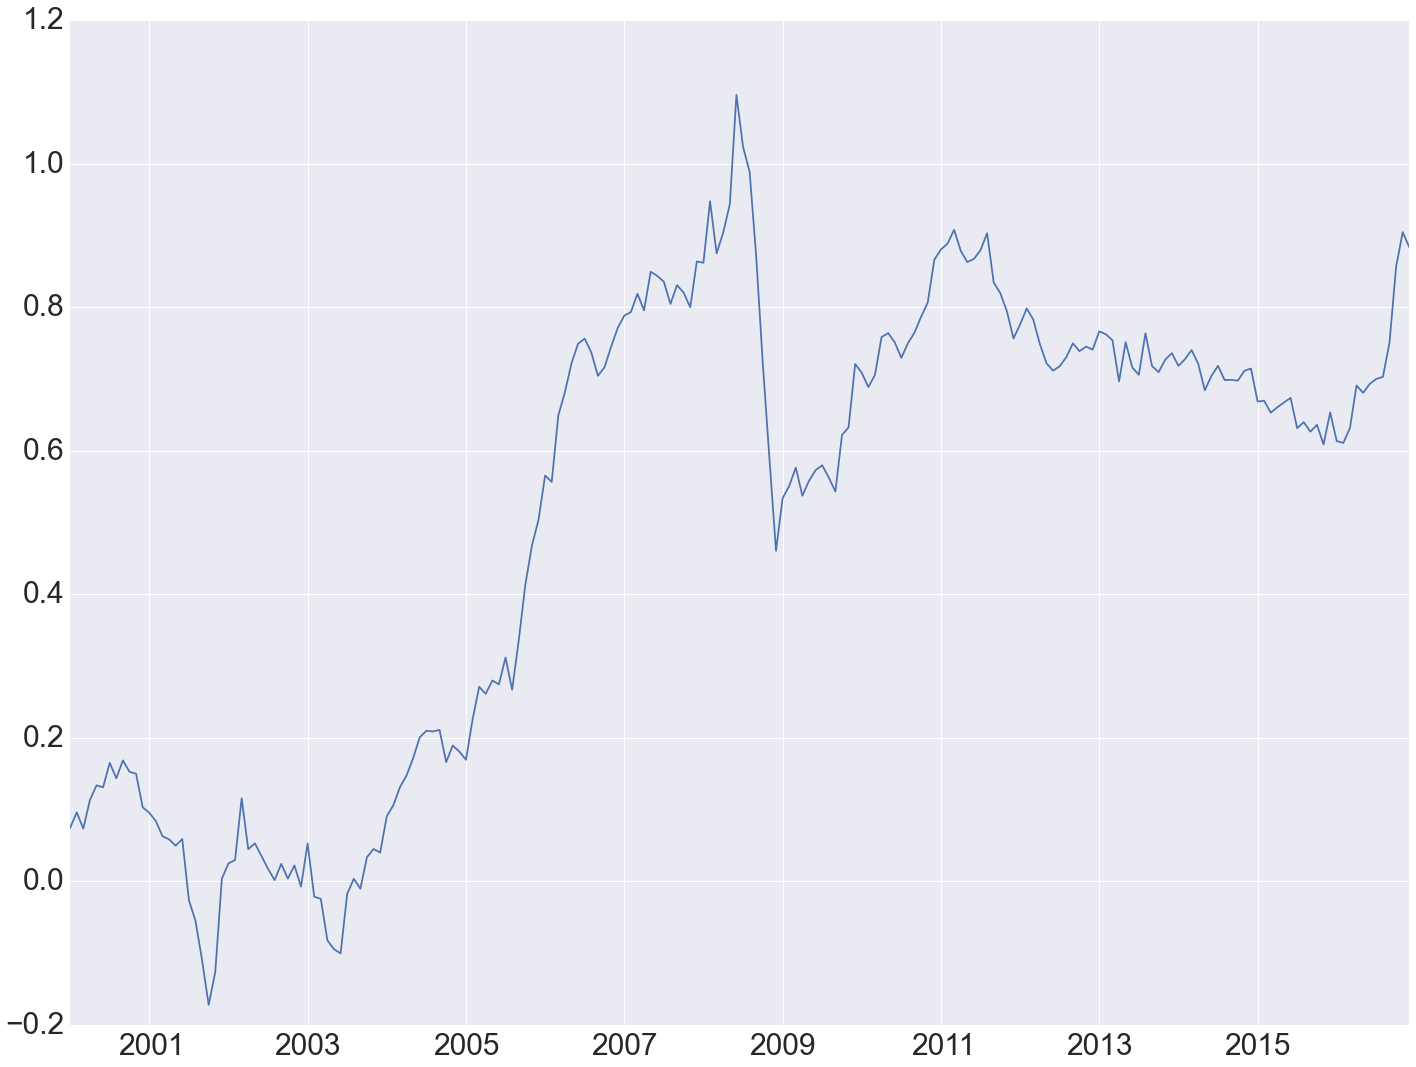

In [139]:
(x['2']-x['0']).cumsum().dropna().plot()